In [2]:
# This notebook shows an example of how to decode the data in the EvAAL API format to pandas DataFrame.
# Please note that the format of the txt file in ../trials/ is what returned through EvAAL API in the competition.
# In the real competition in September, you need to get data throught EvAAL API.

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from PIL import Image
from sub import estimate 


plt.matplotlib.pyplot.rcParams['figure.figsize'] = (16.0, 6.0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [3]:
LOG_FILE_PATH = "../trials/Track5_second_evaluation_01_pdr.txt"
GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [4]:

from collections import defaultdict

# Prepare containers for the data
data = defaultdict(list)

with open(LOG_FILE_PATH) as f:
    for line in f:
        line_contents = line.rstrip('\n').split(';')
        DATA_TYPE = line_contents[0]

        if DATA_TYPE == 'BLUE':
            data['BLUE'].append({
                'ts': float(line_contents[1]),
                'bdaddress': line_contents[2],
                'rssi': int(line_contents[4])
            })

        elif DATA_TYPE in ['ACCE', 'GYRO', 'MAGN']:
            record = {
                'ts': float(line_contents[1]),
                'accuracy': int(line_contents[6]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5])
            }
            data[DATA_TYPE].append(record)
        
        elif DATA_TYPE == 'POS3':
            data['POS3'].append({
                '%time': float(line_contents[1]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5]),
                'q0': float(line_contents[6]),
                'q1': float(line_contents[7]),
                'q2': float(line_contents[8]),
                'q3': float(line_contents[9]),
                'floor': line_contents[10]
            })

# Convert lists of dictionaries to dataframes
blescans = pd.DataFrame(data['BLUE'])
acc = pd.DataFrame(data['ACCE'])
gyro = pd.DataFrame(data['GYRO'])
mgf = pd.DataFrame(data['MAGN'])
gt_ref = pd.DataFrame(data['POS3'])



acc.reset_index(inplace=True, drop=True)
gyro.reset_index(inplace=True, drop=True)
mgf.reset_index(inplace=True, drop=True)
gt_ref.reset_index(inplace=True, drop=True)



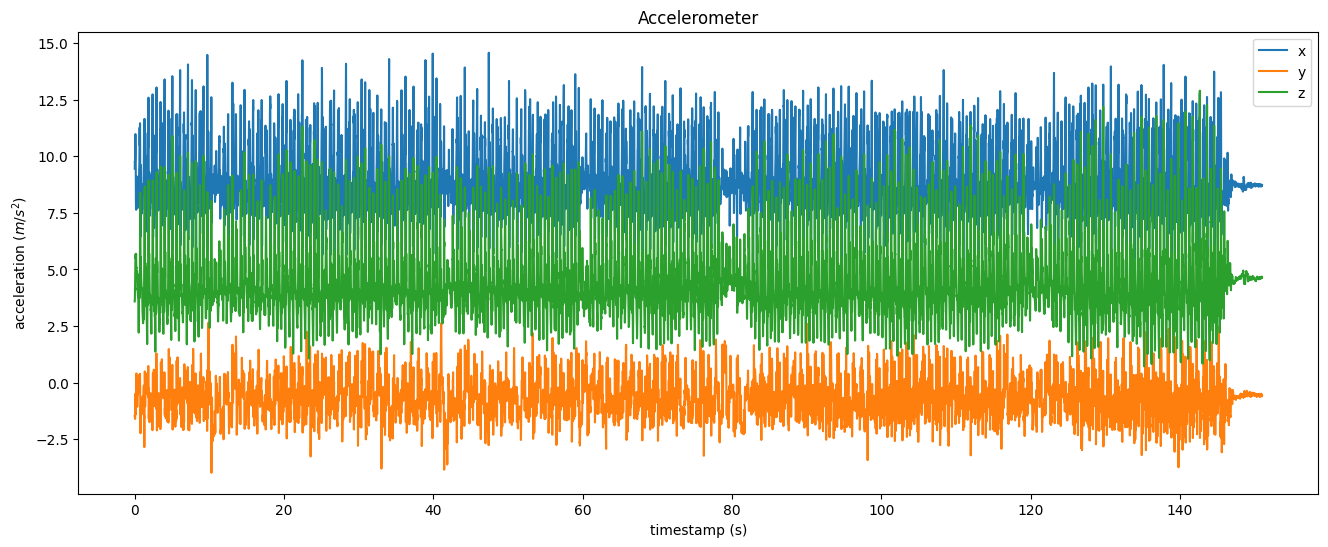

In [5]:

plt.plot(acc.ts, acc[["x", "y", "z"]], label=["x", "y", "z"])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer")
plt.legend()
plt.show()


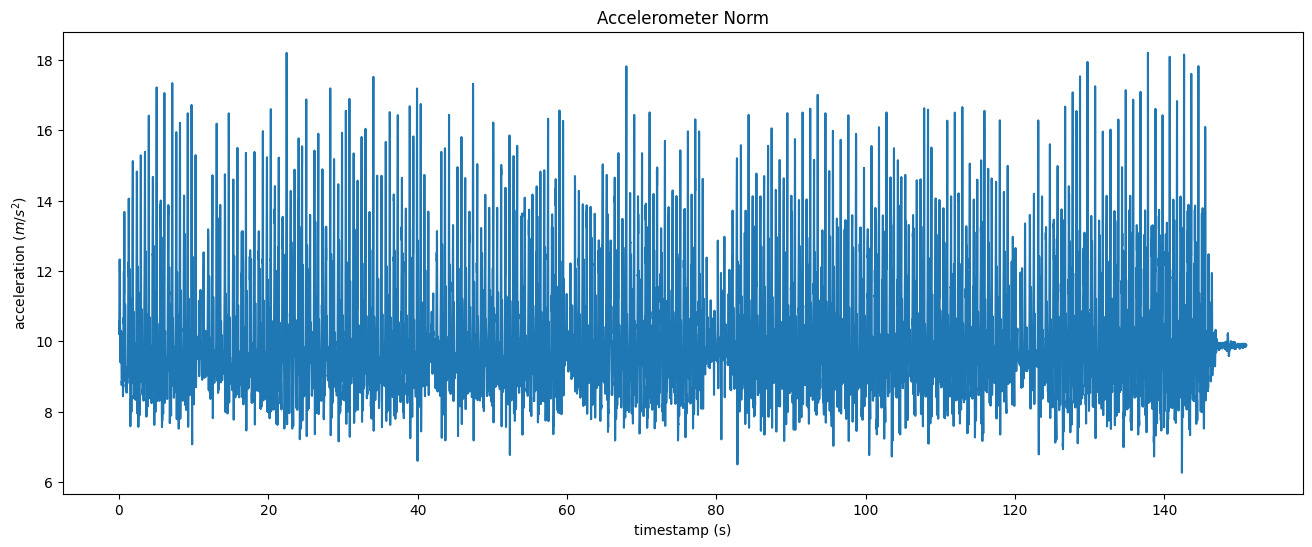

In [6]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)

acc.reset_index()

plt.plot(acc.ts, acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

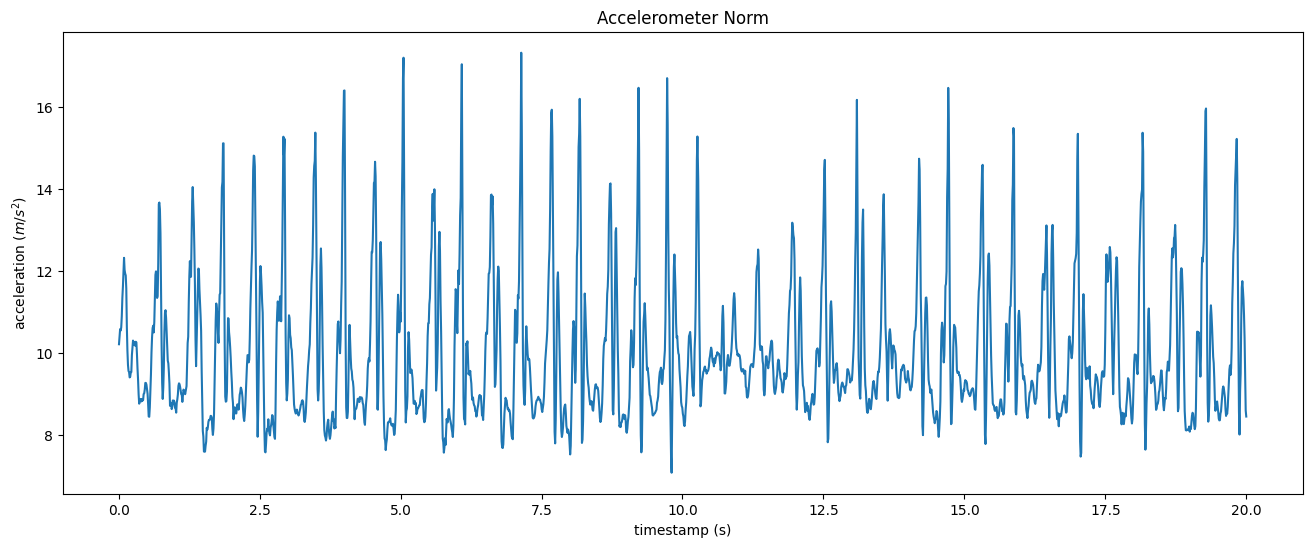

In [7]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)

# 時間が25秒以上50秒未満のデータを抽出
time_filter_acc = acc[(acc.ts >= 0) & (acc.ts < 20)]
time_filter_acc.reset_index(inplace=True, drop=True)

plt.plot(time_filter_acc.ts, time_filter_acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

/var/folders/9p/p2bfdpzj5v5fs4xvn07kwlww0000gn/T/ipykernel_7063/170683450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(


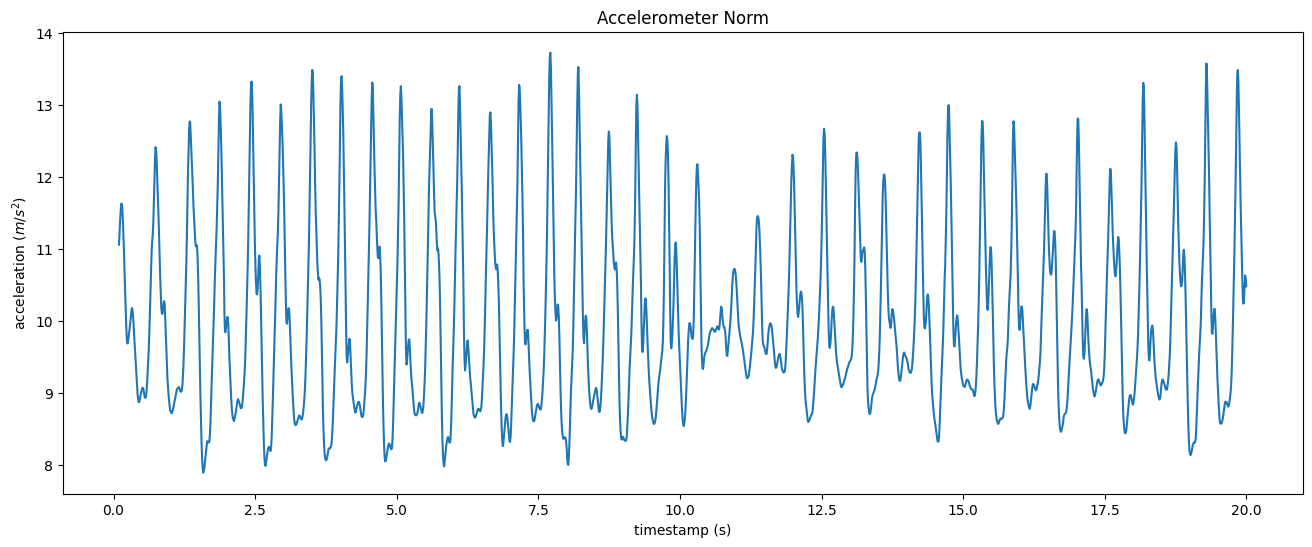

In [8]:

# 移動平均フィルターをかける
time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(
    10).mean()

plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

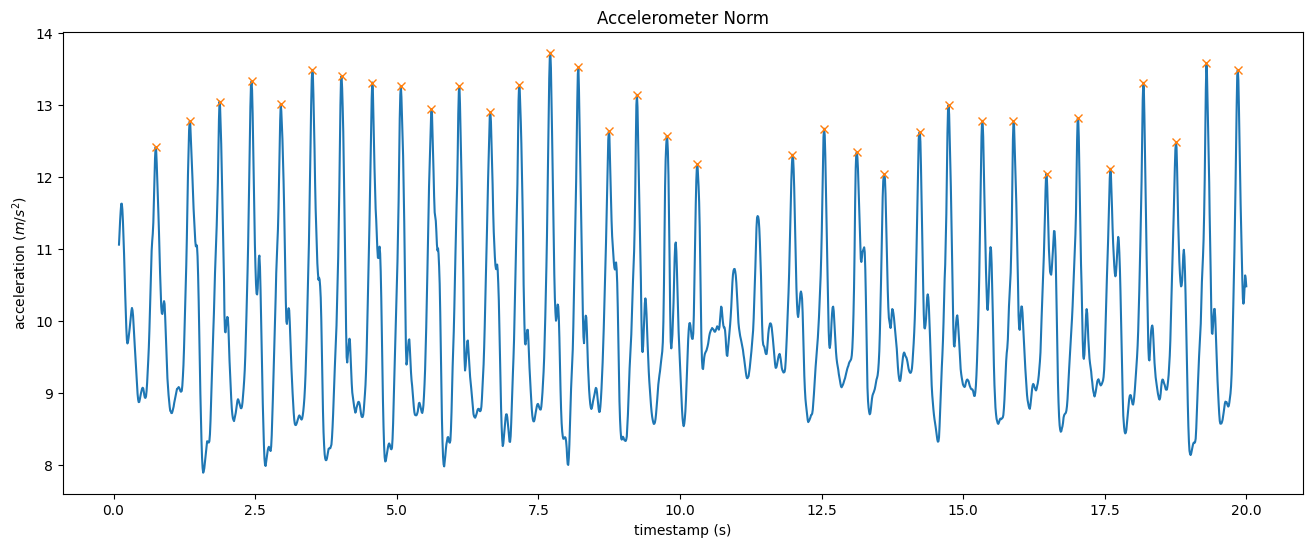

In [9]:
# ピーク検出
from scipy.signal import find_peaks

peaks, _ = find_peaks(time_filter_acc['rolling_norm'], height=12, distance=10)
plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.plot(time_filter_acc.ts[peaks],
         time_filter_acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()


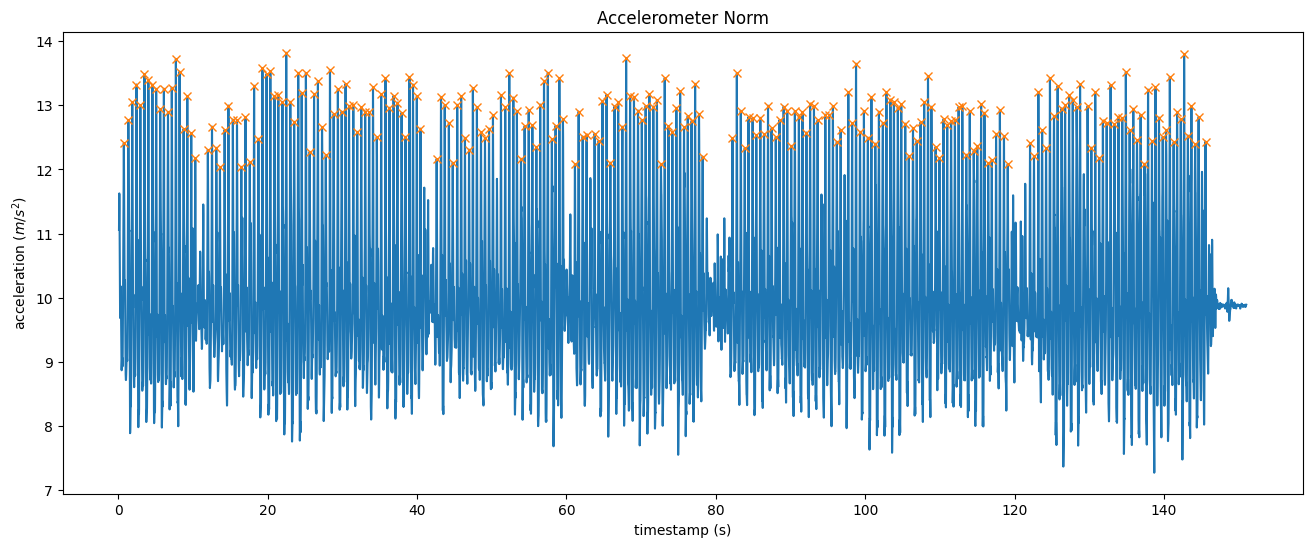

In [10]:

acc['rolling_norm'] = acc['norm'].rolling(10).mean()

peaks, _ = find_peaks(acc['rolling_norm'], height=12, distance=20)

plt.plot(acc.ts, acc['rolling_norm'])
plt.plot(acc.ts[peaks], acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

# time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(
#     10).mean()

# peaks, _ = find_peaks(time_filter_acc['rolling_norm'], height=11, distance=20)

# plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
# plt.plot(time_filter_acc.ts[peaks],
#          time_filter_acc['rolling_norm'][peaks], "x")
# plt.xlabel("timestamp (s)")
# plt.ylabel("acceleration ($m/s^2$)")
# plt.title("Accelerometer Norm")
# plt.show()


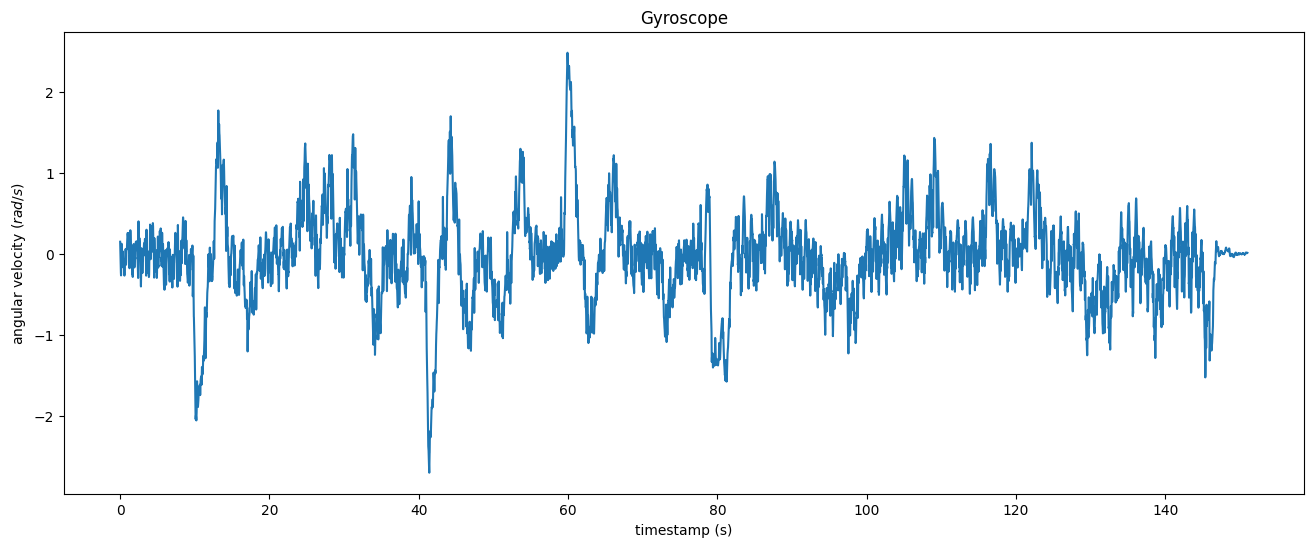

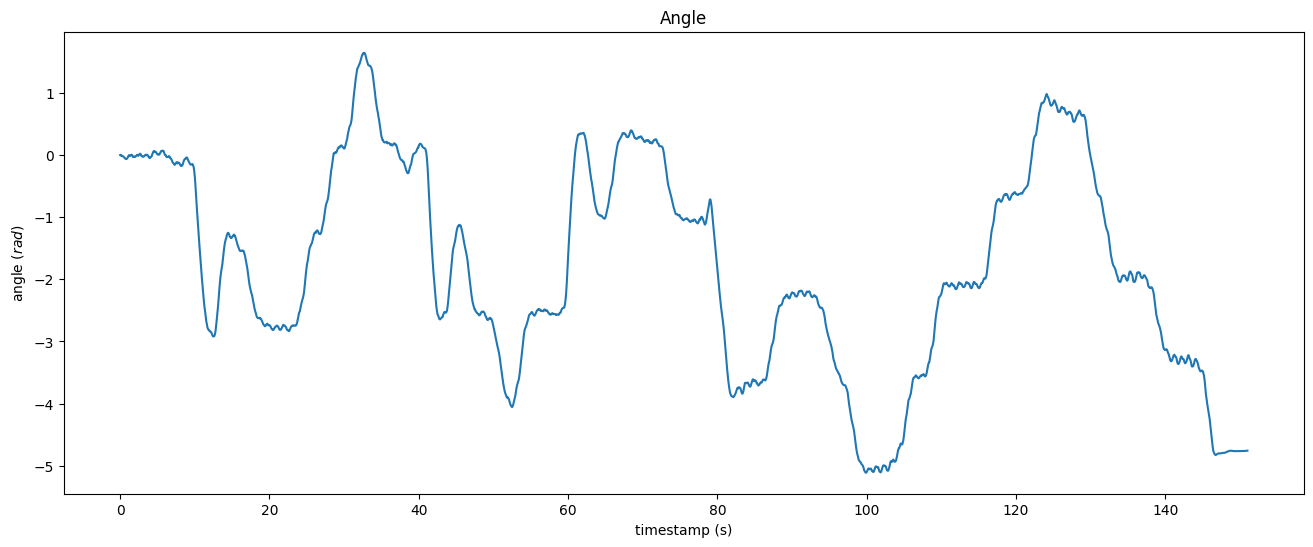

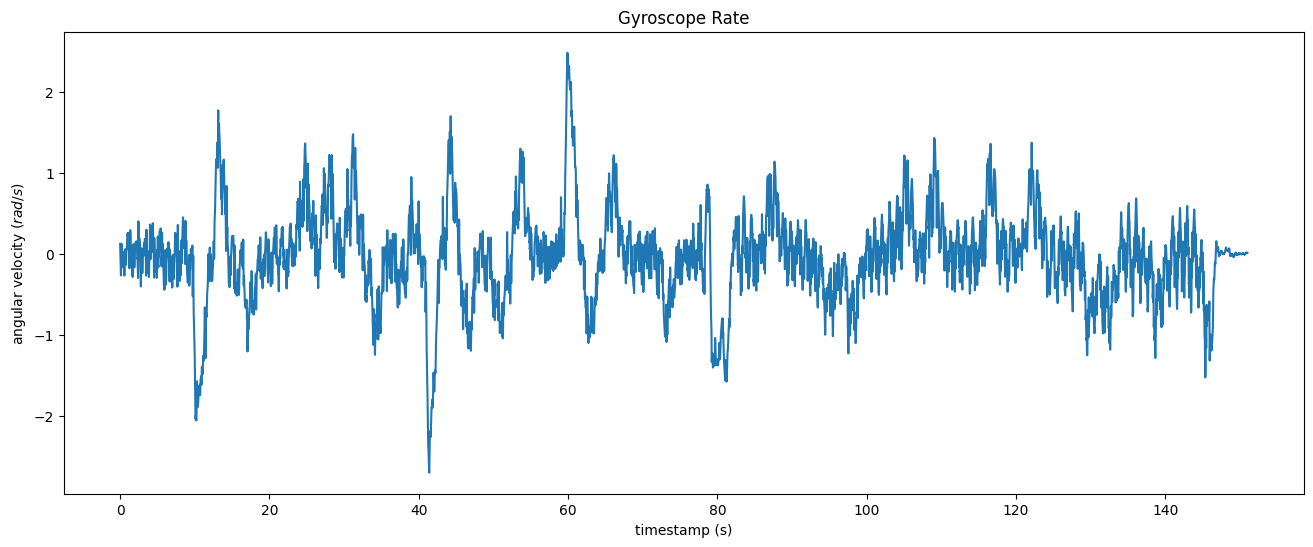

In [11]:

def convert_to_gyro_rate(angle_df: pd.DataFrame) -> pd.DataFrame:
    gyro_rate = pd.DataFrame()
    gyro_rate['ts'] = angle_df['ts']
    # 1つ前の角度との差分を取得して、微分を近似
    # 注意：この方法はノイズが強調される可能性がある
    gyro_rate['x'] = angle_df['x'].diff() / 0.01
    gyro_rate = gyro_rate.dropna()  # 最初のデータポイントでのNaNを削除
    return gyro_rate


plt.plot(gyro.ts, gyro['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angular velocity ($rad/s$)")
plt.title("Gyroscope")
plt.show()

# 角速度を積分して角度に変換
angle_df=estimate.convert_to_angle_from_gyro(gyro)

# 角度のデータをplot
plt.plot(angle_df.ts, angle_df['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()


gyro_rate = convert_to_gyro_rate(angle_df)

# 角速度のデータをplot
plt.plot(gyro_rate.ts, gyro_rate['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angular velocity ($rad/s$)")
plt.title("Gyroscope Rate")
plt.show()


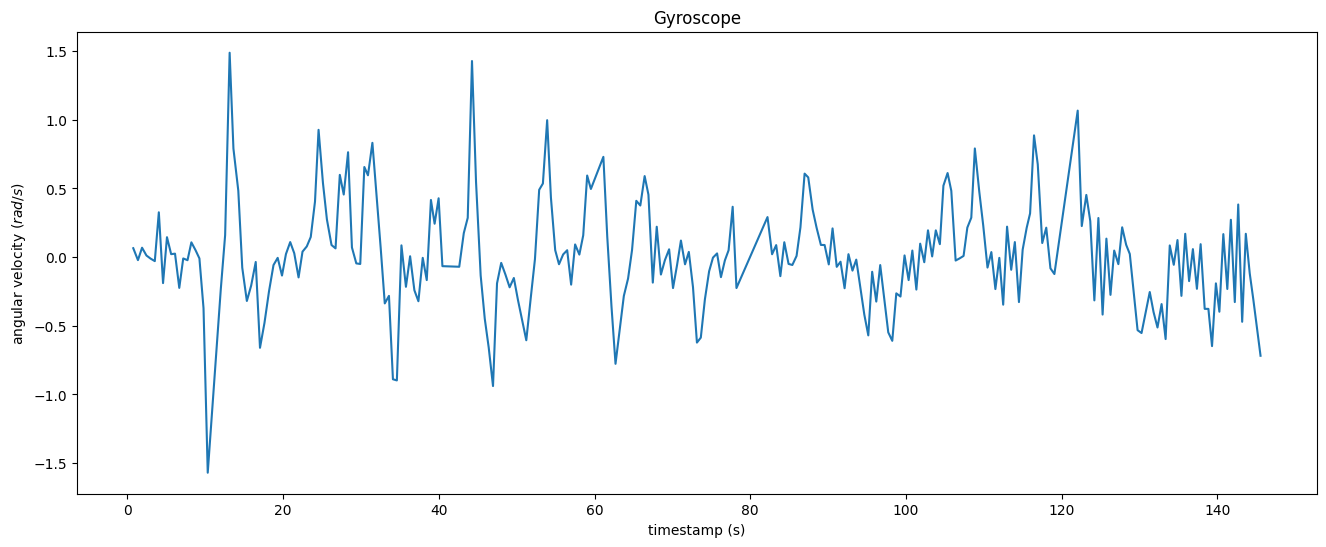

In [12]:

gyro_in_step_timing = pd.DataFrame()
gyro_in_step_timing = estimate.match_data(gyro, acc.ts[peaks])

plt.plot(gyro_in_step_timing.ts, gyro_in_step_timing['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angular velocity ($rad/s$)")
plt.title("Gyroscope")
plt.show()

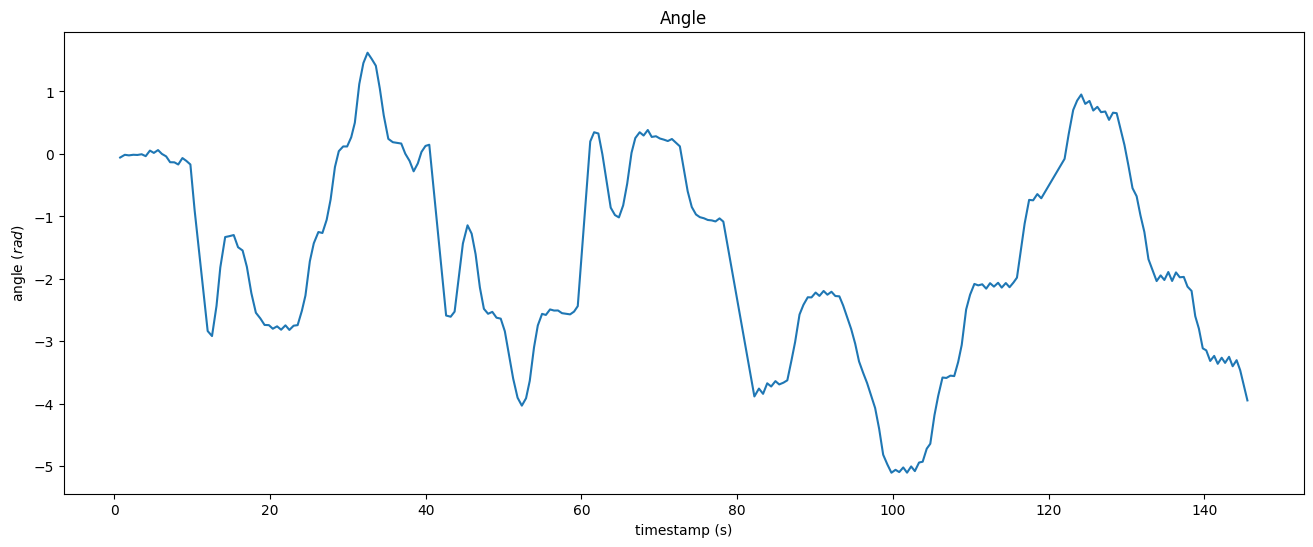

               ts           x
134      1.344094    4.376849
187      1.871418   -0.918130
244      2.436059    0.966389
296      2.952201   -0.314596
352      3.508770    1.130101
404      4.026145   -3.037222
458      4.567823    8.910080
509      5.072773   -3.707952
563      5.610047    4.535064
613      6.106287   -6.144693
668      6.652905   -3.960239
719      7.160331   -9.332799
774      7.711957   -0.191201
824      8.206948   -3.441004
878      8.744222   10.283306
928      9.240465   -4.469701
981      9.767192   -5.802609
1035    10.308846  -73.051543
1204    11.986614 -193.629012
1260    12.543788   -8.066476
1318    13.122751   48.371975
1367    13.608737   61.446935
1430    14.234925   48.743992
1481    14.742351    1.303586
1540    15.333485    1.868637
1596    15.888186  -19.464610
1655    16.473982   -5.240613
1710    17.021205  -26.131594
1768    17.597670  -42.152145
1826    18.179138  -31.435125
1884    18.756486   -9.150761
1938    19.293760  -10.357220
1994    19

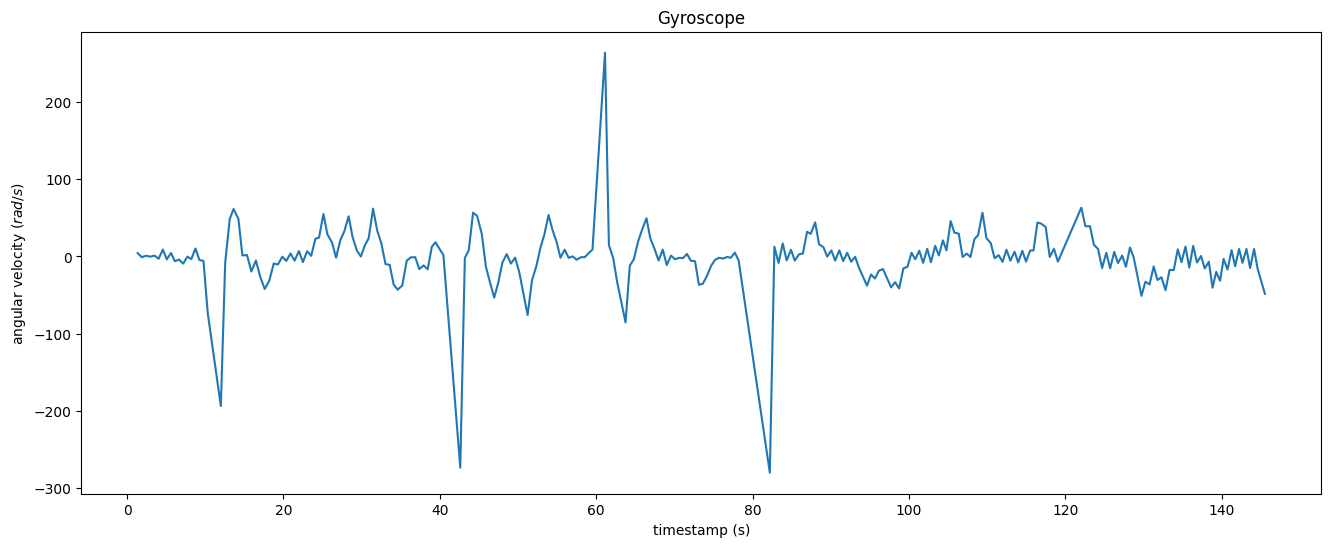

In [13]:


# ジャイロを積分して角度に変換
angle_in_step_timing = pd.DataFrame()

angle_in_step_timing= estimate.convert_to_peek_angle(gyro, acc, peaks)




plt.plot(angle_in_step_timing.ts, angle_in_step_timing['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()




gyro_rate = convert_to_gyro_rate(angle_in_step_timing)

print(gyro_rate)

plt.plot(gyro_rate.ts, gyro_rate['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angular velocity ($rad/s$)")
plt.title("Gyroscope")
plt.show()




In [14]:

dx = 0.01
dy = 0.01

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = estimate.load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp")



edit_map_dict = {}
for floor_name in FLOOR_NAMES:
    edit_map_dict[floor_name] = estimate.load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01_edited.bmp")

floor_name = gt_ref.floor[0] 



               ts  x_displacement  y_displacement
0        0.003490        4.554826        4.524454
74       0.742720        5.053998        4.495704
134      1.344094        5.553951        4.488823
187      1.871418        6.053820        4.477352
244      2.436059        6.553775        4.470712
296      2.952201        7.053708        4.462499
352      3.508770        7.553701        4.459936
404      4.026145        8.053386        4.442192
458      4.567823        8.552668        4.468980
509      5.072773        9.052600        4.477242
563      5.610047        9.551643        4.508160
613      6.106287       10.051643        4.508373
668      6.652905       10.551260        4.488791
719      7.160331       11.046877        4.422733
774      7.711957       11.542367        4.355728
824      8.206948       12.035258        4.271716
878      8.744222       12.534170        4.238744
928      9.240465       13.031110        4.183513
981      9.767192       13.524011        4.099555


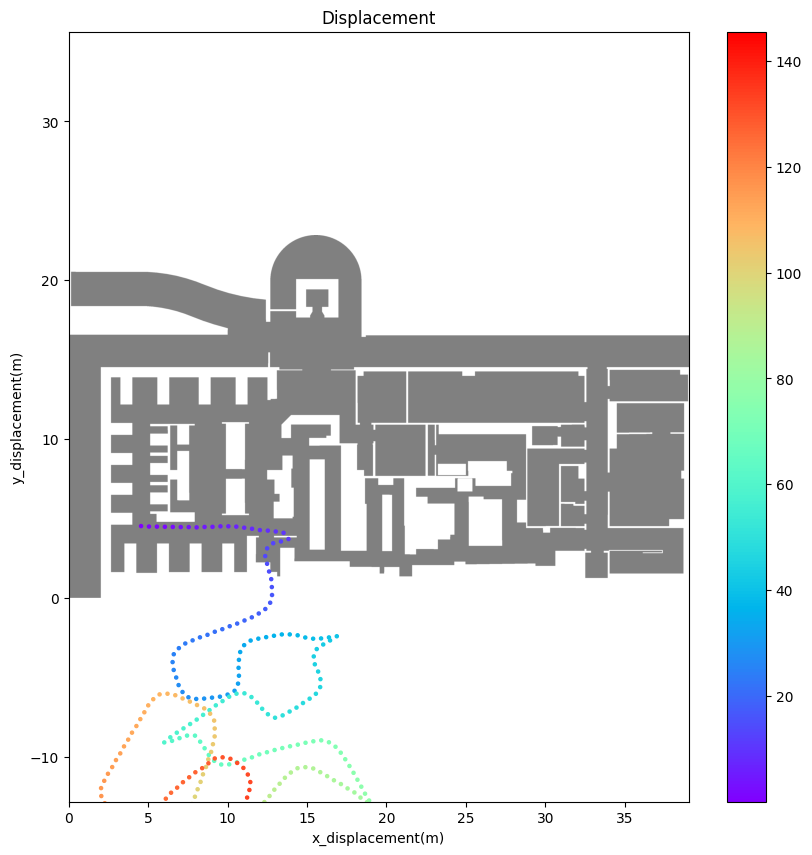

In [15]:

cumulative_displacement_df = estimate.calculate_cumulative_displacement(angle_in_step_timing['ts'], angle_in_step_timing['x'], 0.5, {"x":gt_ref.x[0],"y":gt_ref.y[0]},gt_ref['%time'][0])

print(cumulative_displacement_df)


estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(cumulative_displacement_df.x_displacement, cumulative_displacement_df.y_displacement, c=cumulative_displacement_df.ts, cmap="rainbow",s=5))

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()





1.6131314024621088


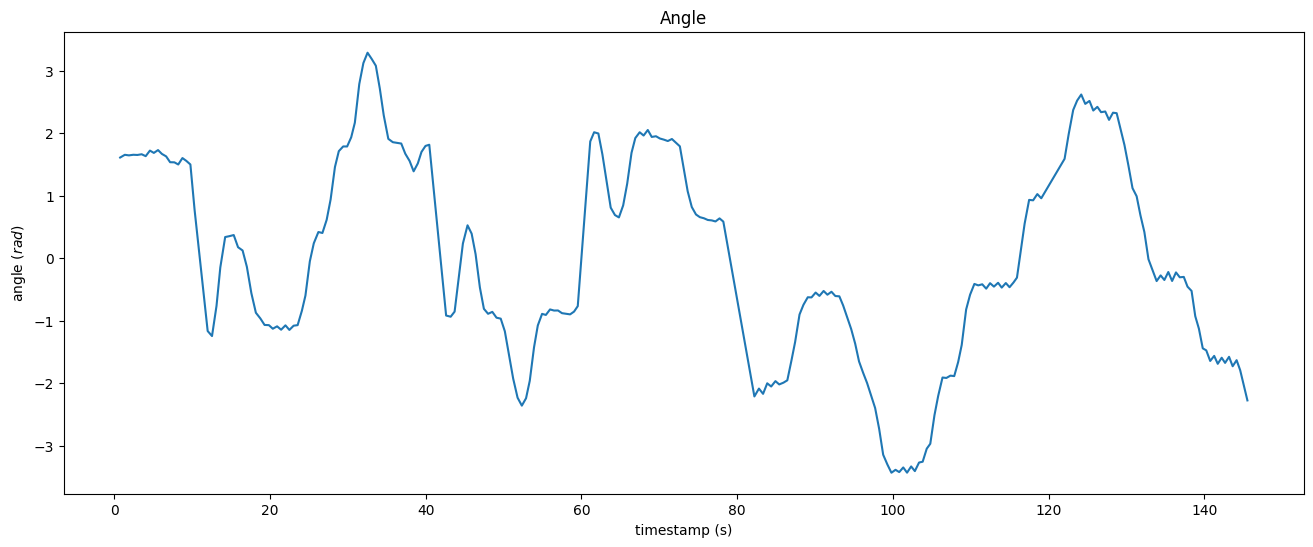

               ts  x_displacement  y_displacement
0        0.003490        4.554826        4.524454
74       0.742720        4.533664        5.024006
134      1.344094        4.490666        5.522153
187      1.871418        4.452243        6.020675
244      2.436059        4.409004        6.518802
296      2.952201        4.367332        7.017062
352      3.508770        4.320032        7.514820
404      4.026145        4.287870        8.013784
458      4.567823        4.211436        8.507908
509      5.072773        4.153372        9.004525
563      5.610047        4.072854        9.497999
613      6.106287        4.022791        9.995486
668      6.652905        3.992464       10.494566
719      7.160331        4.008779       10.994300
774      7.711957        4.026050       11.494001
824      8.206948        4.060502       11.992813
878      8.744222        4.043568       12.492526
928      9.240465        4.048979       12.992497
981      9.767192        4.083376       13.491312


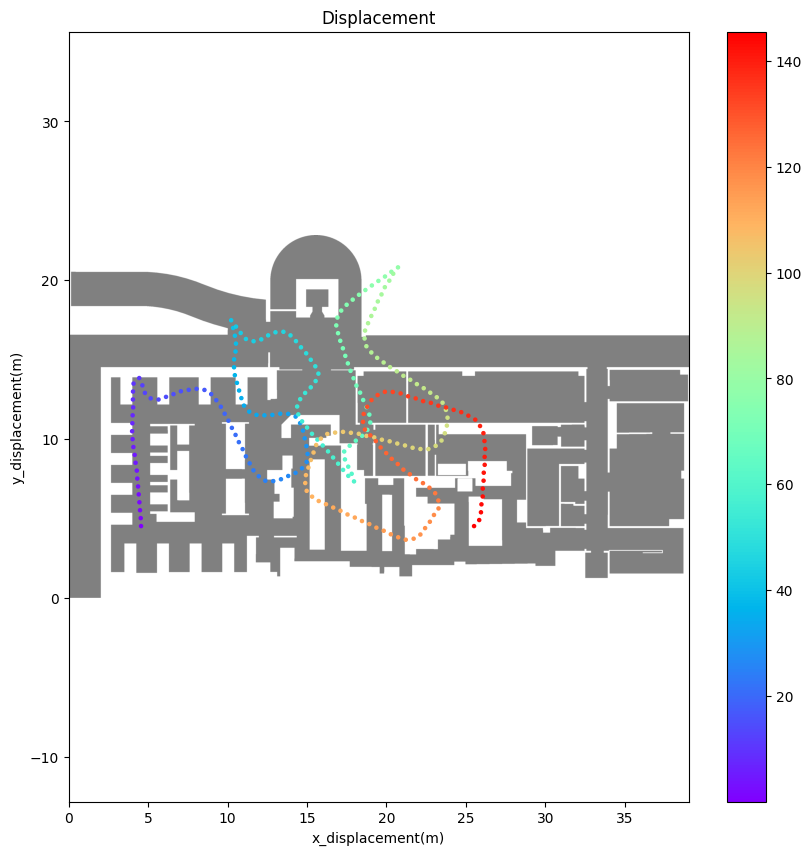

In [16]:

# 軌跡前半の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索
# これは軌跡前半はドリフトが乗りづらいため
#時間全体の中央を変数に入れる

def extract_rotation(quaternions):
    res = R.from_quat(quaternions).apply([1, 0, 0])

    return np.arctan2(res[1], res[0])


initial_direction = extract_rotation([gt_ref.q0[0],gt_ref.q1[0],gt_ref.q2[0],gt_ref.q3[0]])

print(initial_direction)

diff = angle_in_step_timing['x'].values[0] - initial_direction

rotate_by_first_half_angle= pd.DataFrame({
    "ts":angle_in_step_timing.ts,
    "x":angle_in_step_timing.x-diff
})


plt.plot(rotate_by_first_half_angle.ts, rotate_by_first_half_angle['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()



#csvファイルに保存
rotate_by_first_half_angle.to_csv('./output/rotate_by_first_half_angle.csv', index=False,columns=['ts','x'])


rotate_by_first_half_angle_displacement = estimate.calculate_cumulative_displacement(
    rotate_by_first_half_angle.ts, rotate_by_first_half_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])


print(rotate_by_first_half_angle_displacement)

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(rotate_by_first_half_angle_displacement.x_displacement, rotate_by_first_half_angle_displacement.y_displacement,
                c=rotate_by_first_half_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



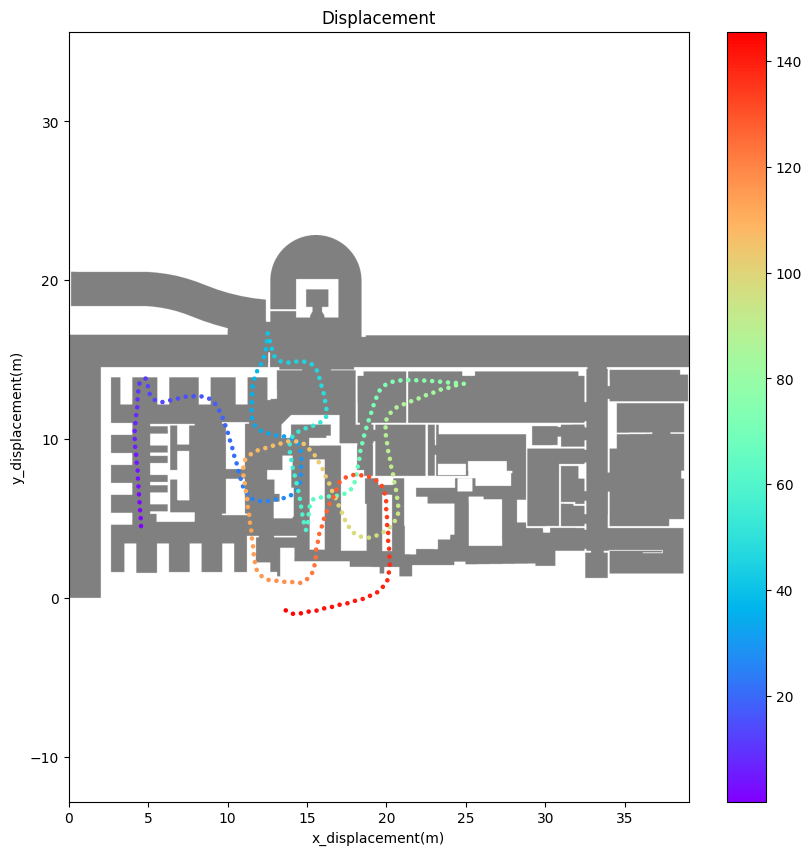

In [17]:


optimal_drift_and_euclidean=estimate.search_optimal_drift_from_angle(rotate_by_first_half_angle,gt_ref)

first_time_remove_drift_angle= pd.DataFrame({
    "ts":rotate_by_first_half_angle.ts,
    "x":rotate_by_first_half_angle.x-optimal_drift_and_euclidean['drift']*(rotate_by_first_half_angle.ts-rotate_by_first_half_angle.ts.iloc[0])
})


first_time_remove_drift_angle_displacement = estimate.calculate_cumulative_displacement(
    first_time_remove_drift_angle.ts, first_time_remove_drift_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(first_time_remove_drift_angle_displacement.x_displacement, first_time_remove_drift_angle_displacement.y_displacement,
                c=first_time_remove_drift_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



6.09


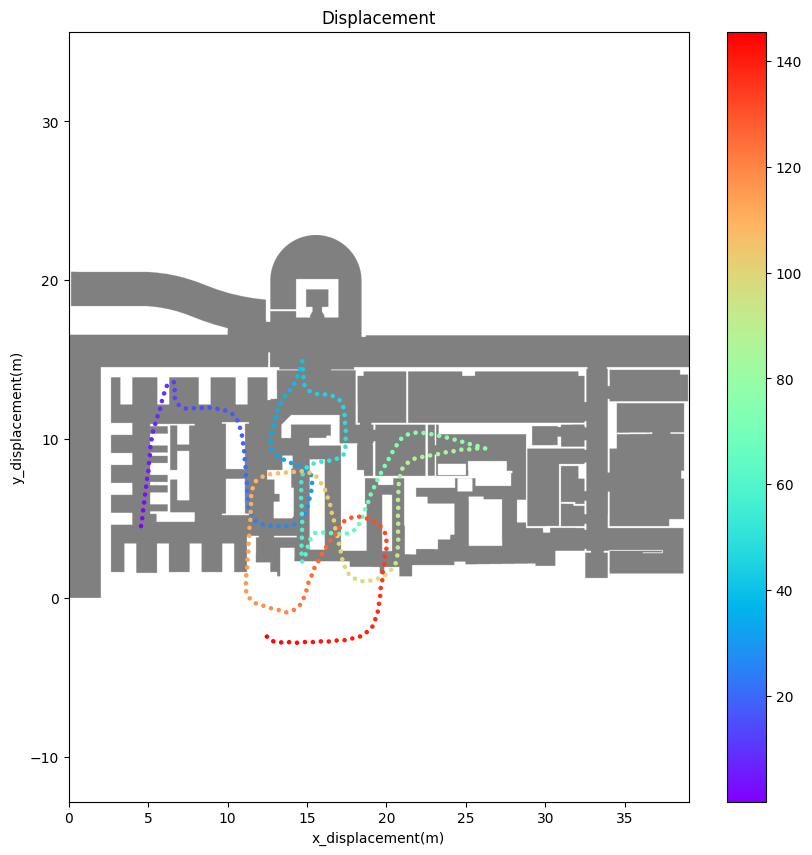

In [18]:

angle_by_vertical_horizontal=estimate.find_best_alignment_angle(
    first_time_remove_drift_angle,gt_ref,edit_map_dict,floor_name,dx,dy)

print(angle_by_vertical_horizontal)


straight_angle=pd.DataFrame({
    "ts":first_time_remove_drift_angle.ts,
    "x":first_time_remove_drift_angle.x+angle_by_vertical_horizontal
})


# plt.plot(straight_angle.ts, straight_angle['x'])
# plt.xlabel("timestamp (s)")
# plt.ylabel("angle ($rad$)")
# plt.title("Angle")
# plt.show()

straight_angle_displacement = estimate.calculate_cumulative_displacement(
    straight_angle.ts, straight_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)

plt.colorbar(
    plt.scatter(straight_angle_displacement.x_displacement, straight_angle_displacement.y_displacement,
                c=straight_angle_displacement.ts, cmap="rainbow",s=5))

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()


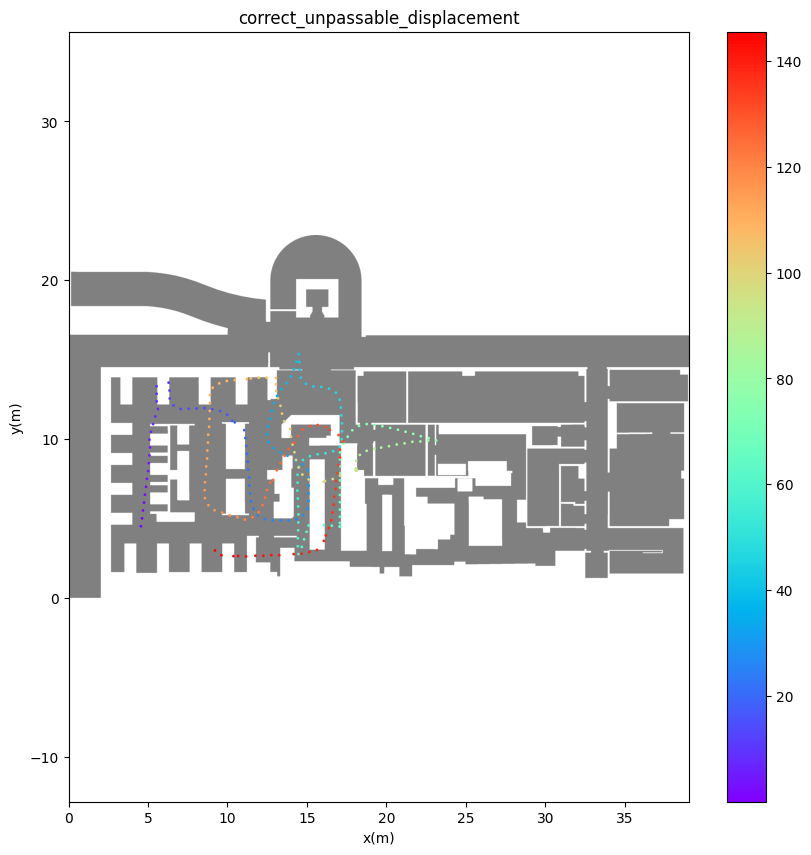

In [19]:
correct_unpassable_displacement = estimate.correct_unpassable_points(straight_angle_displacement[straight_angle_displacement['ts']<180], map_dict, floor_name, dx, dy)

estimate.plot_map(
    map_dict,
    floor_name,
    dx,
    dy,
)

plt.colorbar(
    plt.scatter(
        correct_unpassable_displacement['x_displacement'],
        correct_unpassable_displacement['y_displacement'],
        c=correct_unpassable_displacement['ts'],
        cmap='rainbow',
        s=1
    )
)

plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.title('correct_unpassable_displacement')
plt.show()
